<a href="https://colab.research.google.com/github/SahelKherad/3-story-benchmark-transformer/blob/main/1404_09_01_one_sensor_state0_1_Graphici.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import os
import scipy.io
from scipy.io.matlab._mio5_params import mat_struct
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [62]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [63]:
!ls "/content/drive/My Drive/ASCE"

shm01a.mat  shm03a.mat	shm05a.mat  shm07a.mat	shm09a.mat
shm02a.mat  shm04a.mat	shm06a.mat  shm08a.mat


In [64]:
def load_mat(path):
    mat = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)
    raw = mat.get('dasy')
    if isinstance(raw, mat_struct):
        channels = []
        for f in raw._fieldnames:
            arr = getattr(raw, f)
            channels.append(np.asarray(arr).reshape(-1))
        data = np.stack(channels, axis=1)  # (n_samples, n_channels)
    else:
        raise ValueError("Unexpected MAT structure. 'dasy' not a struct.")
    return data  # float64 by default

base_dir = '/content/drive/MyDrive/ASCE/'
state_files = {
    1: 'shm01a.mat', 2: 'shm02a.mat', 3: 'shm03a.mat',
    4: 'shm04a.mat', 5: 'shm05a.mat', 6: 'shm06a.mat',
    7: 'shm07a.mat', 8: 'shm08a.mat', 9: 'shm09a.mat',
}
# label_to_class_id: 1..9 -> 0..8
label_to_cid = {lab: i for i, lab in enumerate(sorted(state_files.keys()))}

scenario_data = {}   # cid -> np.ndarray [N, C]
for lab, fname in state_files.items():
    x = load_mat(os.path.join(base_dir, fname)).astype(np.float32)
    scenario_data[label_to_cid[lab]] = x
print(scenario_data[0][:,:].shape)
print(scenario_data[0][:,4].shape)
print(scenario_data[4][:,4].shape)
    # print(fname, x.shape)

(60000, 16)
(60000,)
(60000,)


In [65]:
# print(scenario_data[0][:,4].shape)
# print(scenario_data[0][:,4])
# print('Max = ',max(scenario_data[0][:,4]))
# print('Min = ',min(scenario_data[0][:,4]))
# fig , axs = plt.subplots(2,3,figsize=(10,5))
# axs[0,0].plot(scenario_data[0][:win,4])
# axs[0,1].plot(scenario_data[0][win: 2*win,4])
# axs[0,2].plot(scenario_data[0][:,4])

# print(scenario_data[1][:,4].shape)
# print('Max = ',max(scenario_data[1][:,4]))
# print('Min = ',min(scenario_data[1][:,4]))
# axs[1,0].plot(scenario_data[1][:win,4],c='r')
# axs[1,1].plot(scenario_data[1][win:2*win,4], c='r')
# axs[1,2].plot(scenario_data[1][:,4],c='r')


In [66]:
# plt.plot(scenario_data[0][:,14], label='scenario healthy_1')
# plt.plot(scenario_data[8][:,14], label='scenario_9')
# plt.plot(scenario_data[5][:,14], label='scenario_6')
# plt.plot(scenario_data[1][:,14], label='scenario_2')
# plt.legend()

In [67]:
# #  سناریو 0 - تمام سنسورها
# from matplotlib.figure import figaspect
# plt.figure(figsize=(10,2))
# plt.plot(scenario_data[0][:,0], label='sensor_1')
# plt.plot(scenario_data[0][:,1], label='sensor_2')
# plt.plot(scenario_data[0][:,2], label='sensor_3')
# plt.plot(scenario_data[0][:,3], label='sensor_4')
# plt.plot(scenario_data[0][:,4], label='sensor_5')
# plt.plot(scenario_data[0][:,5], label='sensor_6')
# plt.plot(scenario_data[0][:,6], label='sensor_7')
# plt.plot(scenario_data[0][:,7], label='sensor_8')
# plt.plot(scenario_data[0][:,8], label='sensor_9')
# plt.plot(scenario_data[0][:,9], label='sensor_10')
# plt.plot(scenario_data[0][:,10], label='sensor_11')
# plt.plot(scenario_data[0][:,11], label='sensor_12')
# plt.plot(scenario_data[0][:,12], label='sensor_13')
# plt.plot(scenario_data[0][:,13], label='sensor_14')
# plt.plot(scenario_data[0][:,14], label='sensor_15')
# plt.plot(scenario_data[0][:,15], label = 'noise')
# plt.legend()

In [68]:
# #  گوشه شرقی - سناریو شرقی
# from matplotlib.figure import figaspect
# plt.figure(figsize=(10,2))
# plt.plot(scenario_data[0][:,4], label='center_floor_1')
# plt.plot(scenario_data[0][:,7], label='center_floor_2')
# plt.plot(scenario_data[0][:,13], label='center_floor_4')
# plt.plot(scenario_data[0][:,10], label='center_floor_3')
# plt.plot(scenario_data[0][:,1], label='center_base')
# plt.legend()


In [69]:
# #  گوشه غربی - سناریو سالم
# from matplotlib.figure import figaspect
# plt.figure(figsize=(10,2))
# plt.plot(scenario_data[0][:,5], label='center_floor_1')
# plt.plot(scenario_data[0][:,8], label='center_floor_2')
# plt.plot(scenario_data[0][:,14], label='center_floor_4')
# plt.plot(scenario_data[0][:,11], label='center_floor_3')
# plt.plot(scenario_data[0][:,2], label='center_base')
# plt.legend()

In [70]:
# #  گوشه شرقی - سناریو سالم
# from matplotlib.figure import figaspect
# plt.figure(figsize=(10,2))
# plt.plot(scenario_data[0][:,3], label='center_floor_1')
# plt.plot(scenario_data[0][:,6], label='center_floor_2')
# plt.plot(scenario_data[0][:,12], label='center_floor_4')
# plt.plot(scenario_data[0][:,9], label='center_floor_3')
# plt.plot(scenario_data[0][:,0], label='center_base')
# plt.legend()

In [71]:
# # مرکز طبقات - سناریو 2
# from matplotlib.figure import figaspect
# plt.figure(figsize=(10,2))
# plt.plot(scenario_data[1][:,4], label='center_floor_1')
# plt.plot(scenario_data[1][:,7], label='center_floor_2')
# plt.plot(scenario_data[1][:,10], label='center_floor_3')
# plt.plot(scenario_data[1][:,13], label='center_floor_4')
# plt.plot(scenario_data[1][:,1], label='center_base')
# plt.legend()

In [72]:
# #  مرکز ططبقات - سناریو 4
# from matplotlib.figure import figaspect
# plt.figure(figsize=(10,2))
# plt.plot(scenario_data[3][:,4], label='center_floor_1')
# plt.plot(scenario_data[3][:,7], label='center_floor_2')
# plt.plot(scenario_data[3][:,10], label='center_floor_3')
# plt.plot(scenario_data[3][:,13], label='center_floor_4')
# plt.plot(scenario_data[3][:,1], label='center_base')
# plt.legend()

In [73]:
# #  5مرکزز طبقات - سناریو
# from matplotlib.figure import figaspect
# plt.figure(figsize=(10,2))
# plt.plot(scenario_data[4][:,13], label='center_floor_4')
# plt.plot(scenario_data[4][:,10], label='center_floor_3')
# plt.plot(scenario_data[4][:,7], label='center_floor_2')
# plt.plot(scenario_data[4][:,4], label='center_floor_1')
# plt.plot(scenario_data[4][:,1], label='center_base')
# plt.legend()

In [74]:
# #  مرکز طبقات - سناریو6
# from matplotlib.figure import figaspect
# plt.figure(figsize=(10,2))
# plt.plot(scenario_data[5][:,4], label='center_floor_1')
# plt.plot(scenario_data[5][:,7], label='center_floor_2')
# plt.plot(scenario_data[5][:,13], label='center_floor_4')
# plt.plot(scenario_data[5][:,10], label='center_floor_3')
# plt.plot(scenario_data[5][:,1], label='center_base')
# plt.legend()


In [75]:
# #  مرکز طبقات - سناریو 7
# from matplotlib.figure import figaspect
# plt.figure(figsize=(10,2))
# plt.plot(scenario_data[6][:,4], label='center_floor_1')
# plt.plot(scenario_data[6][:,7], label='center_floor_2')
# plt.plot(scenario_data[6][:,10], label='center_floor_3')
# plt.plot(scenario_data[6][:,13], label='center_floor_4')
# plt.plot(scenario_data[6][:,1], label='center_base')
# plt.legend()

In [76]:
# #  گوشه غربی - سناریو 7
# from matplotlib.figure import figaspect
# plt.figure(figsize=(10,2))
# plt.plot(scenario_data[6][:,5], label='center_floor_1')
# plt.plot(scenario_data[6][:,8], label='center_floor_2')
# plt.plot(scenario_data[6][:,11], label='center_floor_3')
# plt.plot(scenario_data[6][:,14], label='center_floor_4')
# plt.plot(scenario_data[6][:,2], label='center_base')
# plt.legend()

In [77]:
# #  گوشه شرقی - سناریو 7
# from matplotlib.figure import figaspect
# plt.figure(figsize=(10,2))
# plt.plot(scenario_data[6][:,3], label='center_floor_1')
# plt.plot(scenario_data[6][:,6], label='center_floor_2')
# plt.plot(scenario_data[6][:,9], label='center_floor_3')
# plt.plot(scenario_data[6][:,11], label='center_floor_4')
# plt.plot(scenario_data[6][:,0], label='center_base')
# plt.legend()

In [78]:
# #  داده های مرکز - سناریو 9
# from matplotlib.figure import figaspect
# plt.figure(figsize=(10,2))

# plt.plot(scenario_data[8][:,7], label='center_floor_2')
# plt.plot(scenario_data[8][:,10], label='center_floor_3')
# plt.plot(scenario_data[8][:,13], label='center_floor_4')
# plt.plot(scenario_data[8][:,4], label='center_floor_1')
# plt.plot(scenario_data[8][:,1], label='center_base')
# plt.legend()

In [79]:
# #  سنسور مرکز طبقه اول در دو سناریو
# healthy_data = scenario_data[0][:,4]
# damaged_data = scenario_data[8][:,4]

# #  سنسور گوشه شرقی طبقه اول در دو سناریو
# healthy_data = scenario_data[0][:,3]
# damaged_data = scenario_data[8][:,3]

# #  سنسور گوشه غربی طبقه اول در دو سناریو
# healthy_data = scenario_data[0][:,5]
# damaged_data = scenario_data[8][:,5]

In [80]:
# #  سنسور مرکز طبقه اول در دو سناریو
# healthy_data = scenario_data[0][:,4]
# damaged_data = scenario_data[5][:,4]

# #  سنسور گوشه شرقی طبقه اول در دو سناریو
# healthy_data = scenario_data[0][:,3]
# damaged_data = scenario_data[5][:,3]

# #  سنسور گوشه غربی طبقه اول در دو سناریو
# healthy_data = scenario_data[0][:,5]
# damaged_data = scenario_data[5][:,5]

In [81]:
# #  سنسور مرکز طبقه دوم در دو سناریو
# healthy_data = scenario_data[0][:,7]
# damaged_data = scenario_data[8][:,7]

#  سنسور گوشه شرقی طبقه دوم در دو سناریو
healthy_data = scenario_data[0][:,6]
damaged_data = scenario_data[8][:,6]

# #  سنسور گوشه غریی طبقه دوم در دو سناریو
# healthy_data = scenario_data[0][:,8]
# damaged_data = scenario_data[8][:,8]

In [82]:
#  سنسور مرکز طبقه دوم در دو سناریو
# healthy_data = scenario_data[0][:,7]
# damaged_data = scenario_data[5][:,7]

#  سنسور گوشه شرقی طبقه دوم در دو سناریو
# healthy_data = scenario_data[0][:,6]
# damaged_data = scenario_data[5][:,6]

# #  سنسور گوشه غریی طبقه دوم در دو سناریو
# healthy_data = scenario_data[0][:,8]
# damaged_data = scenario_data[5][:,8]

In [83]:
#  سنسور مرکز طبقه سوم در دو سناریو
# healthy_data = scenario_data[0][:,10]
# damaged_data = scenario_data[8][:,10]

# #  سنسور گوشه شرقی طبقه سوم در دو سناریو
# healthy_data = scenario_data[0][:,9]
# damaged_data = scenario_data[8][:,9]

# #  سنسور گوشه غربی طبقه سوم در دو سناریو
# healthy_data = scenario_data[0][:,11]
# damaged_data = scenario_data[8][:,11]

In [84]:
# #  سنسور مرکز طبقه چهارم در دو سناریو
# healthy_data = scenario_data[0][:,13]
# damaged_data = scenario_data[8][:,13]

# #  سنسور گوشه شرقی طبقه چهارم در دو سناریو
# healthy_data = scenario_data[0][:,12]
# damaged_data = scenario_data[8][:,12]

# #  سنسور گوشه غربی طبقه چهارم در دو سناریو
# healthy_data = scenario_data[0][:,14]
# damaged_data = scenario_data[8][:,14]

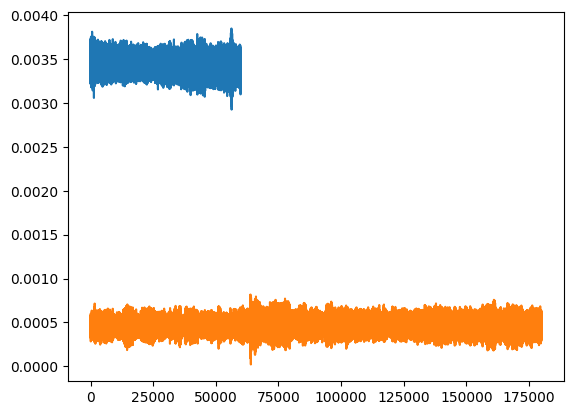

In [85]:
plt.plot(healthy_data)
plt.plot(damaged_data)

In [86]:
n_train = 0.6
n_val = 0.2

m_0 = int(n_train * len(healthy_data))
l_0 = int(n_val * len(healthy_data))

m_1 = int(n_train * len(damaged_data))
l_1 = int(n_val * len(damaged_data))

X_train_0 = healthy_data[0:m_0]
X_val_0 = healthy_data[m_0 :m_0+l_0]
X_test_0 = healthy_data[m_0+l_0:]

X_train_1 = damaged_data[0:m_1]
X_val_1 = damaged_data[m_1 :m_1+l_1]
X_test_1 = damaged_data[m_1+l_1:]

In [87]:
print('x_train_o.shape:', X_train_0.shape)
print('x_val_o.shape:', X_val_0.shape)
print('x_test_o.shape:', X_test_0.shape)

x_train_o.shape: (36000,)
x_val_o.shape: (12000,)
x_test_o.shape: (12000,)


In [88]:
con = np.concatenate([X_train_0,X_train_1])
print(con.shape)
mu = con.mean(axis=(0) , keepdims = True)
print('mu:',mu)
std = con.std(axis=(0), keepdims=True) + 1e-6

(144000,)
mu: [0.0012122]


In [89]:
X_train_0 = (X_train_0 - mu) / std
X_val_0   = (X_val_0   - mu) / std
X_test_0  = (X_test_0  - mu) / std

X_train_1 = (X_train_1 - mu) / std
X_val_1   = (X_val_1   - mu) / std
X_test_1  = (X_test_1  - mu) / std

In [90]:
print(X_train_0.shape)
print(X_val_0.shape)
print(X_test_0.shape)

(36000,)
(12000,)
(12000,)


In [91]:

def make_windows_with_stride(data, window_length, stride):

    num_frames = int((len(data) - window_length) // (stride + 1e-8) + 1)
    print(num_frames)

    if num_frames <= 0:
        return np.empty((0, window_length), dtype=data.dtype)


    start_indices = np.arange(num_frames) * stride
    window_indices = start_indices[:, None] + np.arange(window_length)
    windows = data[window_indices]

    return windows

In [92]:
win = 512
stride = 512

In [93]:
# 2) Make windows per class
X_train_0 = make_windows_with_stride(X_train_0, win, stride)
X_val_0   = make_windows_with_stride(X_val_0, win, stride)
X_test_0  = make_windows_with_stride(X_test_0, win, stride)

y_0 = np.zeros((X_train_0.shape[0]+X_val_0.shape[0]+X_test_0.shape[0]), dtype=np.int64)

print('Train_0 = \n')
print(X_train_0.shape)
print(X_val_0.shape)
print(X_test_0.shape)
print(y_0.shape)

X_train_1 = make_windows_with_stride(X_train_1, win, stride)
X_val_1 = make_windows_with_stride(X_val_1, win, stride)
X_test_1 = make_windows_with_stride(X_test_1, win, stride)

y_1 = np.ones((X_train_1.shape[0]+X_val_1.shape[0]+X_test_1.shape[0]), dtype=np.int64)

print('\n Train_1 = \n')
print(X_train_1.shape)
print(X_val_1.shape)
print(X_test_1.shape)
print(y_1.shape)

70
23
23
Train_0 = 

(70, 512)
(23, 512)
(23, 512)
(116,)
210
70
70

 Train_1 = 

(210, 512)
(70, 512)
(70, 512)
(350,)


In [94]:
# def make_windows(data, window_length, drop_last : bool = True):
#     # Calculate how many full frames can be created
#     num_frames = len(data) // window_length
#     # print(num_frames)
#     # Trim the data to be a perfect multiple of the frame length
#     trimmed_data = data[:num_frames * window_length]

#     # Reshape the data into a 2D array of frames
#     windows = trimmed_data.reshape((num_frames, window_length))
#     # return trimmed_data.shape , frames.shape
#     return windows

In [95]:
# win = 300
# 2) Make windows per class
# X_train_0 = make_windows(X_train_0, win, drop_last=True)
# X_val_0 = make_windows(X_val_0, win, drop_last=True)
# X_test_0 = make_windows(X_test_0, win, drop_last=True)

# y_0 = np.zeros((X_train_0.shape[0]+X_val_0.shape[0]+X_test_0.shape[0]), dtype=np.int64)

# print('Train_0 = \n')
# print(X_train_0.shape)
# print(X_val_0.shape)
# print(X_test_0.shape)
# print(y_0.shape)

# X_train_1 = make_windows(X_train_1, win, drop_last=True)
# X_val_1 = make_windows(X_val_1, win, drop_last=True)
# X_test_1 = make_windows(X_test_1, win, drop_last=True)

# y_1 = np.ones((X_train_1.shape[0]+X_val_1.shape[0]+X_test_1.shape[0]), dtype=np.int64)

# print('\n Train_1 = \n')
# print(X_train_1.shape)
# print(X_val_1.shape)
# print(X_test_1.shape)
# print(y_1.shape)

In [96]:
X_train = np.vstack([X_train_0, X_train_1])[:, :, None]  # [N, 5, 1]
print(X_train.shape)

y_train = np.concatenate([y_0[0:int(len(X_train_0))], y_1[0:int(len(X_train_1))]])             # [N]
print(y_train)
print(y_train.shape)

(280, 512, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(280,)


In [97]:
rng = np.random.default_rng(42)
perm = rng.permutation(len(X_train))

X_train = X_train[perm]
y_train = y_train[perm]
print(y_train)

[1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 1 0 0 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0
 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1
 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0
 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1
 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1]


In [98]:
X_val = np.vstack([X_val_0, X_val_1])[:, :, None]  # [N, 5, 1]
print(X_val.shape)

y_val = np.concatenate([y_0[int(len(X_train_0)):int(len(X_train_0) + len(X_val_0))], y_1[int(len(X_train_1)):int(len(X_train_1) + len(X_val_1))]])             # [N]
print(y_val)
print(y_val.shape)

(93, 512, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(93,)


In [99]:
X_test =  np.vstack([X_test_0, X_test_1])[:, :, None]  # [N, 5, 1]
print(X_test.shape)

y_test = np.concatenate([y_0[int(len(X_train_0) + len(X_val_0)):], y_1[int(len(X_train_1) + len(X_val_1)):]], axis=0)             # [N]
print(y_test)
print(y_test.shape)

(93, 512, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(93,)


In [100]:
# 5) Torch tensors
X_train = torch.from_numpy(X_train).float()  # float32
y_train = torch.from_numpy(y_train).long()  # int64
X_val   = torch.from_numpy(X_val).float()
y_val   = torch.from_numpy(y_val).long()
X_test  = torch.from_numpy(X_test).float()
y_test  = torch.from_numpy(y_test).long()

In [101]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([280, 512, 1]) torch.Size([280])
torch.Size([93, 512, 1]) torch.Size([93])
torch.Size([93, 512, 1]) torch.Size([93])


In [102]:
class SeqDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X  # [N, seq_len, 1]
        self.y = y  # [N]
    def __len__(self): return self.y.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = SeqDataset(X_train, y_train)
# print(X_train.shape)
# print(train_ds[0])
# print(train_ds[1])
# print(train_ds[2])
val_ds   = SeqDataset(X_val,   y_val)
test_ds  = SeqDataset(X_test,  y_test)

In [103]:
# 6) DataLoaders: shuffle only the training set
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [104]:
with torch.no_grad():
    ys_tr = torch.cat([yb.view(-1) for _, yb in train_loader], dim=0).cpu()
    ys_va = torch.cat([yb.view(-1) for _, yb in val_loader], dim=0).cpu()

print("train label set/counts:", ys_tr.unique(return_counts=True))
print("val   label set/counts:", ys_va.unique(return_counts=True))
print("train min/max:", ys_tr.min().item(), ys_tr.max().item())
print("val   min/max:", ys_va.min().item(), ys_va.max().item())

train label set/counts: (tensor([0, 1]), tensor([ 70, 210]))
val   label set/counts: (tensor([0, 1]), tensor([23, 70]))
train min/max: 0 1
val   min/max: 0 1


In [105]:
# 7) Example: adapt a batch for a Transformer [seq_len, batch, d_model]
xb, yb = next(iter(train_loader))   # xb: [B, 5, 1]

In [106]:
class LearnablePositionalEncoding(nn.Module):
    """
    Learnable positional encoding added to token embeddings.
    Shape stored: [1, max_len, d_model]
    """
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        self.pe = nn.Parameter(torch.zeros(1, max_len, d_model))
        print(self.pe)
        nn.init.trunc_normal_(self.pe, std=0.02)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        return x + self.pe[:, :T, :]

In [107]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=256, nhead=4, num_layers=3, d_ff=256, seq_len= X_train.shape[1], num_classes=2, dropout=0.1):
        super().__init__()
        self.inp = nn.Linear(1, d_model)                            # project feature_dim=1 -> d_model
        self.pos = LearnablePositionalEncoding(d_model, seq_len)    # learnable PE
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True                                        # so we keep [B, T, d]
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: [B, T, 1]
        x = self.inp(x)                  # [B, T, d]
        x = self.pos(x)                  # add learnable PE
        x = self.encoder(x)              # [B, T, d]
        x = self.norm(x)
        x = x.mean(dim=1)                # mean pool over time

        logits = self.head(x)            # [B, C]
        return logits

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = X_train.shape[1]
num_classes = 2
model = TimeSeriesTransformer(
    d_model=16,
    nhead=2,
    num_layers=2,
    d_ff=6,
    seq_len=seq_len ,
    num_classes=2,
    dropout=0.1).to(device)

Parameter containing:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)


In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device) # Move the model to the selected device

Using device: cpu


TimeSeriesTransformer(
  (inp): Linear(in_features=1, out_features=16, bias=True)
  (pos): LearnablePositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=6, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=6, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=16, out_features=2, bias=True)
)

In [110]:
# from torch.optim.lr_scheduler import CosineAnnealingLR
# # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0)
# # loss_fn = nn.CrossEntropyLoss()
# from torch.optim.lr_scheduler import CosineAnnealingLR
# scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 80
tr_losses, tr_accs, val_losses, val_accs = [], [], [], []

for epoch in range(num_epochs):
     model.train()
     total_loss, total_samples, correct_predictions = 0, 0, 0
     for xb, yb in train_loader:
        xb , yb = xb.to(device) , yb.to(device).long()
        optimizer.zero_grad()
        output = model(xb)
        # print('output',output)
        # print('max',torch.max(output, 1))
        # print('yb',yb)

        loss = loss_fn(output , yb)
        # print('loss',loss)
        # optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        # print(loss.item())
        # print(xb.size(0))
        # print('total:',total_loss)

        # Calculate accuracy
        pred = output.argmax(dim=1) # the index of the maximum value for each column
        # print('p',predicted)
        # print('real',yb)
        total_samples += xb.size(0)
        # print(total_samples)
        correct_predictions += (pred == yb).sum().item()
        # print(correct_predictions)

     epoch_loss = total_loss / total_samples
     epoch_accuracy = correct_predictions / total_samples
     tr_losses.append(epoch_loss)
     tr_accs.append(epoch_accuracy)

    #  print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f}")

     model.eval()
     val_correct_predictions , val_total_samples , val_total_loss = 0 , 0 , 0

     with torch.no_grad():
          for xb, yb in val_loader:
              xb, yb = xb.to(device), yb.to(device).long()
              output = model(xb)
              val_loss = loss_fn(output,yb)
              val_total_loss += val_loss.item() * xb.size(0)
              pred = output.argmax(dim=1)
              val_total_samples += xb.size(0)
              val_correct_predictions += (pred == yb).sum().item()

     val_epoch_loss = val_total_loss / val_total_samples
     val_epoch_accuracy = val_correct_predictions / val_total_samples
    #  print(    f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")
     val_losses.append(val_epoch_loss)
     val_accs.append(val_epoch_accuracy)
     # 3) Step the scheduler once per epoch, after validation
    #  scheduler.step()

     # Optional: print current lr to confirm schedule
     current_lr = optimizer.param_groups[0]["lr"]
     print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f} | "f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")




Epoch 1/80: Train Loss: 0.4408, Train Accuracy: 0.7643 | Validation Loss: 0.3193, Validation Accuracy: 1.0000

Epoch 2/80: Train Loss: 0.2840, Train Accuracy: 1.0000 | Validation Loss: 0.2032, Validation Accuracy: 1.0000

Epoch 3/80: Train Loss: 0.1831, Train Accuracy: 1.0000 | Validation Loss: 0.1298, Validation Accuracy: 1.0000

Epoch 4/80: Train Loss: 0.1217, Train Accuracy: 1.0000 | Validation Loss: 0.0856, Validation Accuracy: 1.0000

Epoch 5/80: Train Loss: 0.0828, Train Accuracy: 1.0000 | Validation Loss: 0.0603, Validation Accuracy: 1.0000

Epoch 6/80: Train Loss: 0.0606, Train Accuracy: 1.0000 | Validation Loss: 0.0450, Validation Accuracy: 1.0000

Epoch 7/80: Train Loss: 0.0469, Train Accuracy: 1.0000 | Validation Loss: 0.0354, Validation Accuracy: 1.0000

Epoch 8/80: Train Loss: 0.0378, Train Accuracy: 1.0000 | Validation Loss: 0.0292, Validation Accuracy: 1.0000

Epoch 9/80: Train Loss: 0.0318, Train Accuracy: 1.0000 | Validation Loss: 0.0248, Validation Accuracy: 1.0000

E

In [ ]:
import torch.nn.functional as F
val_probs = []
val_true  = []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        val_probs.append(F.softmax(out, dim=1).max(1).values.cpu())
        val_true.append(yb)
val_probs = torch.cat(val_probs)
print('Val avg max-softmax:', val_probs.mean().item())

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
all_pred, all_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        all_pred.append(out.argmax(1).cpu().numpy())
        all_true.append(yb.numpy())
cm = confusion_matrix(np.concatenate(all_true), np.concatenate(all_pred))
print(cm)

In [ ]:
epoch = np.arange(0,num_epochs , 1)
import matplotlib.pyplot as plt

plt.plot(epoch, tr_losses , label="Train_loss", c='b')
plt.plot(epoch, val_losses, label="val_losss", c='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_true, y_pred, y_score = [], [], []
model.eval()

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device).long()   # targets should be int for CE
        logits = model(xb)                             # [B,2]

        # 1) Probability of class 1
        probs  = torch.softmax(logits, dim=1)          # [B,2]
        score1 = probs[:, 1]                           # [B]

        # 2) Predicted class index
        preds  = logits.argmax(dim=1)                  # [B]

        # Save results
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
        y_score.extend(score1.cpu().tolist())

# 1) Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()

# 2) ROC
RocCurveDisplay.from_predictions(y_true, y_score)
plt.title("ROC Curve (Validation)")
plt.show()

# 3) Precision–Recall
PrecisionRecallDisplay.from_predictions(y_true, y_score)
plt.title("Precision–Recall Curve (Validation)")
plt.show()

In [ ]:



from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

model.eval()
all_embeds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        # Pass through encoder only (skip classifier head)
        embeds = model.encoder(model.inp(xb) + model.pos(model.inp(xb)))
        embeds = embeds.mean(dim=1)                # [B, d_model]

        all_embeds.append(embeds.cpu())
        all_labels.append(yb.cpu())

# Concatenate all batches
all_embeds = torch.cat(all_embeds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Run t-SNE
X_2d = TSNE(n_components=2, random_state=42).fit_transform(all_embeds)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=all_labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Class")
plt.title("t-SNE of Validation Embeddings")
plt.show()